In [26]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.optimizers import RMSprop
from keras.losses import Huber

In [4]:
#Train_data is a cleaned train_FD001
train_data=pd.read_csv("Train_data.csv")

#Engine number 21 sensor readings are used as the test
test_data=pd.read_csv("test_engine_21.csv")

In [5]:
train_data.head()

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,R_early
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125


In [6]:
test_data.head()

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,R_early
0,21,1,642.24,1582.88,1410.66,553.57,2388.07,9047.42,47.44,521.76,2388.06,8128.48,8.4181,395,38.90,23.3554,125
1,21,2,642.27,1582.13,1404.54,553.22,2388.03,9043.88,47.25,521.39,2388.05,8120.15,8.3895,392,38.81,23.2300,125
2,21,3,642.47,1589.73,1408.88,553.21,2388.11,9048.33,47.43,521.26,2388.12,8124.89,8.4454,392,38.69,23.3471,125
3,21,4,642.50,1587.18,1409.45,553.30,2388.05,9052.17,47.35,521.81,2388.08,8126.21,8.3913,393,39.00,23.4179,125
4,21,5,642.21,1596.51,1401.46,553.03,2388.04,9047.48,47.57,521.82,2388.10,8130.92,8.4825,393,38.88,23.2637,125


In [7]:
#Normalize the training set
cols_normalize = train_data.columns.difference(['id','cycle','R_early'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_data[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_data.index)
join_df = train_data[train_data.columns.difference(cols_normalize)].join(norm_train_df)
train_data = join_df.reindex(columns = train_data.columns)
print(train_data.head())

   id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8   sensor9  \
0   1      1  0.183735  0.406802  0.309757  0.726248  0.242424  0.109755   
1   1      2  0.283133  0.453019  0.352633  0.628019  0.212121  0.100242   
2   1      3  0.343373  0.369523  0.370527  0.710145  0.272727  0.140043   
3   1      4  0.343373  0.256159  0.331195  0.740741  0.318182  0.124518   
4   1      5  0.349398  0.257467  0.404625  0.668277  0.242424  0.149960   

   sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  \
0  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333  0.713178   
1  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333  0.666667   
2  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667  0.627907   
3  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333  0.573643   
4  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667  0.589147   

   sensor21  R_early  
0  0.724662      125  
1  0.731014      125  
2  0.621375      125  


In [8]:
#Normalize the test set
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_data[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_data.index)
test_join_df = test_data[test_data.columns.difference(cols_normalize)].join(norm_test_df)
test_data = test_join_df.reindex(columns = test_data.columns)
test_data = test_data.reset_index(drop=True)
print(test_data.head())

   id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8   sensor9  \
0  21      1  0.310241  0.258121  0.479575  0.599034  0.257576  0.115274   
1  21      2  0.319277  0.241770  0.376266  0.542673  0.196970  0.099390   
2  21      3  0.379518  0.407456  0.449527  0.541063  0.318182  0.119357   
3  21      4  0.388554  0.351864  0.459149  0.555556  0.227273  0.136588   
4  21      5  0.301205  0.555265  0.324274  0.512077  0.212121  0.115543   

   sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  \
0  0.351190  0.654584  0.264706  0.147280  0.358599  0.583333  0.589147   
1  0.238095  0.575693  0.250000  0.104294  0.248557  0.333333  0.519380   
2  0.345238  0.547974  0.352941  0.128754  0.463640  0.333333  0.426357   
3  0.297619  0.665245  0.294118  0.135566  0.255483  0.416667  0.666667   
4  0.428571  0.667377  0.323529  0.159872  0.606387  0.416667  0.573643   

   sensor21  R_early  
0  0.636841      125  
1  0.463684      125  
2  0.625380      125  


In [9]:
train_data.head()

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,R_early
0,1,1,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,125
1,1,2,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,125
2,1,3,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,125
3,1,4,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,125
4,1,5,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,125


In [10]:
# Sliding window size of 40 cycles
sequence_length = 40

# function to reshape features into (samples, time steps, features) 

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length),
                           range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [11]:
#  Select useful sensors only feature columns
sequence_cols = ['sensor2','sensor3','sensor4','sensor7','sensor8','sensor9',
                 'sensor11','sensor12','sensor13','sensor14','sensor15',
                 'sensor17','sensor20','sensor21']

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_data[train_data['id']==id], 
                             sequence_length, sequence_cols)) 
           for id in train_data['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)


(16631, 40, 14)


In [12]:
# function to generate labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_data[train_data['id']==id], sequence_length,
                        ['R_early']) 
             for id in train_data['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(16631, 1)

In [13]:
# Metrics using keras backend
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [14]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# Create Model

In [29]:
# Clear artifacts and set random seed to ensure repeatability
keras.backend.clear_session()
np.random.seed(42)

# Define metrics
def rmse(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

def r2_keras(y_true, y_pred):
    ss_total = keras.backend.sum(keras.backend.square(y_true - keras.backend.mean(y_true)))
    ss_residual = keras.backend.sum(keras.backend.square(y_true - y_pred))
    return 1 - (ss_residual / (ss_total + keras.backend.epsilon()))

# Create model
def DCNN(sequence_length, nb_features, nb_out):
    model = Sequential()
    model.add(Conv1D(32, 8, padding='same', activation='relu',
                     input_shape=(sequence_length, nb_features)))
    model.add(Conv1D(64, 8, padding='same', activation='relu'))
    model.add(Conv1D(64, 8, padding='same', activation='relu'))
    model.add(Conv1D(32, 8, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    
    optimizer = RMSprop(learning_rate=1e-5)
    model.compile(loss=Huber(),
                  optimizer=optimizer,
                  metrics=[rmse, r2_keras])
    
    return model

# Create model checkpoint to save the best model performance
model_checkpoint = ModelCheckpoint("my_checkpoint.h5", save_best_only=True)

# Specify early stopping to stop training if there's no improvement after 10 epochs
early_stopping = EarlyStopping(patience=10)

# Example usage
sequence_length = 40  # Example value
nb_features = 14        # Example value
nb_out = 1              # Example value

# Create the model
New_DCNN = DCNN(sequence_length, nb_features, nb_out)
New_DCNN.summary()

# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(New_DCNN, show_shapes=True, rankdir="LR")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            3616      
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 64)            16448     
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 64)            32832     
                                                                 
 conv1d_3 (Conv1D)           (None, 40, 32)            16416     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

In [30]:
# Train the model
history = New_DCNN.fit(seq_array,label_array, epochs=500, batch_size=200,
                       validation_split=0.2,callbacks=[early_stopping, 
                        model_checkpoint])

Epoch 1/500
67/67 [==============================] - 3s 20ms/step - loss: 76.0478 - rmse: 86.9969 - r2_keras: -3.4520 - val_loss: 81.4917 - val_rmse: 90.0860 - val_r2_keras: -8.7608
Epoch 2/500
67/67 [==============================] - 1s 14ms/step - loss: 75.7450 - rmse: 86.7992 - r2_keras: -3.4347 - val_loss: 81.1458 - val_rmse: 89.7803 - val_r2_keras: -8.7001
Epoch 3/500
67/67 [==============================] - 1s 15ms/step - loss: 75.3287 - rmse: 86.3610 - r2_keras: -3.3875 - val_loss: 80.6494 - val_rmse: 89.3387 - val_r2_keras: -8.6127
Epoch 4/500
67/67 [==============================] - 1s 15ms/step - loss: 74.7307 - rmse: 85.8343 - r2_keras: -3.3283 - val_loss: 79.9360 - val_rmse: 88.6986 - val_r2_keras: -8.4865
Epoch 5/500
67/67 [==============================] - 1s 17ms/step - loss: 73.8807 - rmse: 85.1358 - r2_keras: -3.2526 - val_loss: 78.9108 - val_rmse: 87.7697 - val_r2_keras: -8.3046
Epoch 6/500
67/67 [==============================] - 1s 17ms/step - loss: 72.6309 - rmse: 

In [31]:
#load the best state of the model
model= load_model("my_checkpoint.h5", custom_objects={'r2_keras': r2_keras,'rmse':rmse})

In [32]:
# generate test sequences and convert to numpy array
test_gen = (list(gen_sequence(test_data[test_data['id']==id], sequence_length,
            sequence_cols)) for id in test_data['id'].unique())

# generate sequences and convert to numpy array
test_gen = np.concatenate(list(test_gen)).astype(np.float32)
#print(seq_array_test_last)
print(test_gen.shape)

(155, 40, 14)


In [33]:
# generate test labels
test_target = [gen_labels(test_data[test_data['id']==id], sequence_length,
               ['R_early']) for id in test_data['id'].unique()]

y_true = np.concatenate(test_target).astype(np.float32)
y_true.shape

(155, 1)

In [34]:
#predict on the test data
RUL_pred = model.predict(test_gen)

5/5 [==============================] - 0s 2ms/step


In [35]:
RUL_pred.shape

(155, 1)

In [36]:
y_true.shape

(155, 1)

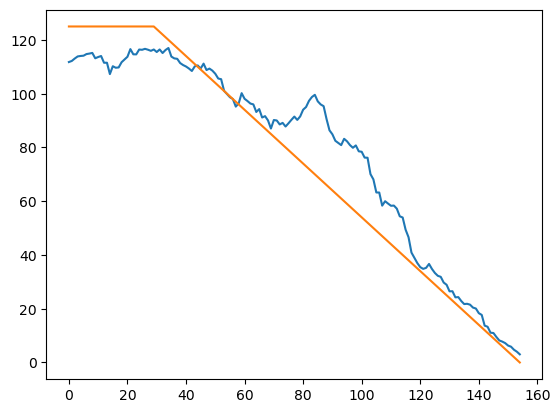

In [37]:
#Plot the predicted versus true RUL trend
time = np.arange(test_gen.shape[0])
plt.plot(time,RUL_pred)
plt.plot(time, y_true)
plt.show()

dict_keys(['loss', 'rmse', 'r2_keras', 'val_loss', 'val_rmse', 'val_r2_keras'])


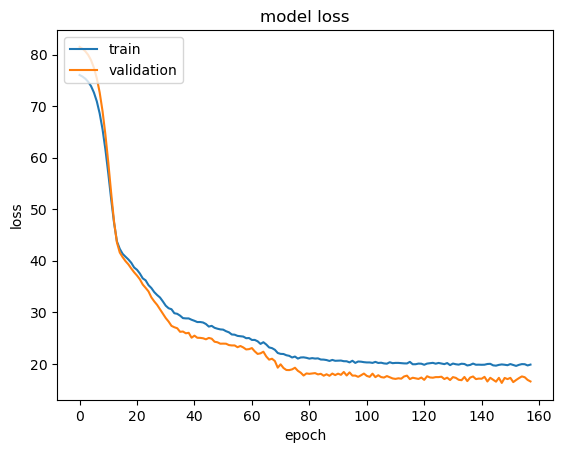

In [38]:
#Plot the losses  
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
#Estimate the model average rmse
final_mse = keras.metrics.mean_squared_error(y_true, RUL_pred)
final_rmse = np.sqrt(final_mse)
final_rmse
np.mean(final_rmse)

9.318501